Fazendo download da base de dados

In [ ]:
!wget https://github.com/yancoltro/image_classification/raw/master/PetImages.zip
!unzip -q PetImages.zip
!ls

Listando nossas pastas e contando nossos arquivos

In [ ]:
!ls PetImages
!echo "Quantidade de dados de gatos: $(ls -1 PetImages/Cat | wc -l)" 
!echo "Quantidade de dados de cães: $(ls -1 PetImages/Dog | wc -l)" 

Removendo imagens possivelmente corrompidas

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"): # laço para percorrer nossa estrutura de pastas
    folder_path = os.path.join("PetImages", folder_name) #montando o caminho para buscar as imagens
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) #contatenando o nome do da pasta com cada nome de arquivo
        try:
            # imagens JPG tem a string JFIF no começo de seu cabeçalho, codificada em bytes
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # gerar os bytes da string JFIF, e verificar se encontra correspondencia entre os 10 primeiros bytes do arquivo
        finally:
            fobj.close() # fecha o arquivo

        if not is_jfif:
            num_skipped += 1 # incremente
            os.remove(fpath) #deleta o arquivo corrompido

print("Foram deletadas %d imagens da base de dados." % num_skipped)

In [ ]:
!echo "Restaram $(ls -1 PetImages/Cat | wc -l) imagens de gatos." 
!echo "Restaram $(ls -1 PetImages/Dog | wc -l) imagens de cães." 

Gerando um dataset

In [ ]:
image_size = (180, 180) #tamanho que irão ser redimensionadas as imagens

In [ ]:

batch_size = 32 #valor padrão, de qual tamanho serão os lotes

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages", #caminho
    validation_split=0.2, #quantidade fracionada para validação
    subset="training", # conjunto ao qual as imagens pertecerão
    seed=1337, # embaralhamento
    image_size=image_size, #tamanho da imagem
    batch_size=batch_size, #tamanho do lote
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Visualizando parte do nosso conjunto de treinamento

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = "Cachorro" if int(labels[i]) == 1  else "Gato"
        # plt.title(int(labels[i]))
        plt.title(title)
        plt.axis("off")

**Data Augmentation**

Declaração da função do nosso data augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        # layers.Rescaling(1./255)
    ]
)
# esse data augmentation rescaling exemplifica como o algorimto irá "enxergar" as imagens
data_augmentation_rescaling = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.Rescaling(1./255)
    ]
)

Como isso afeta nossos dados?

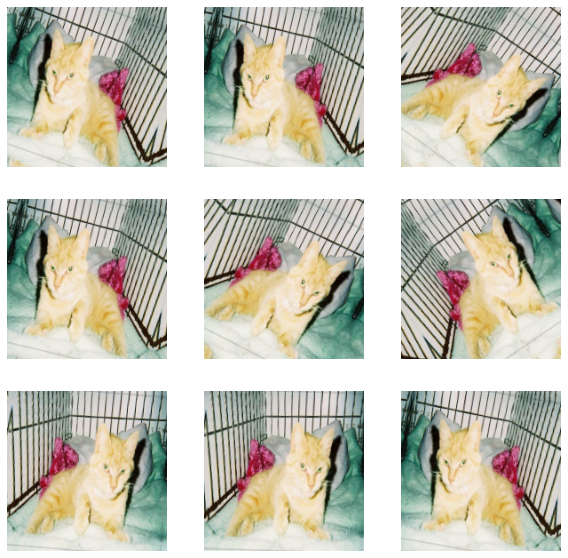

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
        # plt.show()
        # augmented_images_rescaling = data_augmentation_rescaling(images)
        # ax_rescaling = plt.subplot(3, 3, i + 1)
        # plt.imshow(augmented_images_rescaling[0].numpy().astype("uint8"))
        # plt.show()

In [17]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Vamos treinar o modelo? Acho que isso pode levar alguns dias!!

In [ ]:
# epochs = 50

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#     train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
# )

In [19]:
from keras import models
from keras.models import save_model
from keras.models import load_model

Exportando o modelo treinado com as 500 imagens de gatos e cachorros

In [ ]:
# save_model(model, f'trained_model.h5')

Importando o modelo e os pesos já treinados

In [27]:
trained_model = load_model( f'trained_model.h5')

1/1 [==============================] - 1s 663ms/step
This image is 79.38 percent cat and 20.62 percent dog.


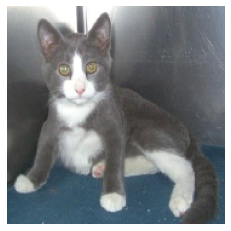

In [28]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/441.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = trained_model.predict(img_array)
score = predictions[0]
plt.imshow(img)
plt.axis("off")
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)